In [1]:
!pip install rho-plus
!pip install matminer
!pip install scikit-learn==1.3.2

# Neural Networks: A Practical Introduction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rho_plus as rp

# as before: set to whichever mode you prefer
theme, cs = rp.mpl_setup(is_dark=False)

We load the dataset and compute preset descriptors. This is taken from the matminer example notebook
and not something I want to worry about right now. Instead, focus on how we learn from the data.

In [3]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.structure import DensityFeatures
from matminer.featurizers.conversions import CompositionToOxidComposition
from matminer.featurizers.composition import OxidationStates


from matminer.datasets.convenience_loaders import load_elastic_tensor
df = load_elastic_tensor()


unwanted_columns = ["volume", "nsites", "compliance_tensor", "elastic_tensor",
                    "elastic_tensor_original", "K_Voigt", "G_Voigt", "K_Reuss", "G_Reuss"]
df = df.drop(unwanted_columns, axis=1)

df = StrToComposition().featurize_dataframe(df, "formula")
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df = ep_feat.featurize_dataframe(df, col_id="composition")  # input the "composition" column to the featurizer

df = CompositionToOxidComposition().featurize_dataframe(df, "composition")

os_feat = OxidationStates()
df = os_feat.featurize_dataframe(df, "composition_oxid")
df.head()

df_feat = DensityFeatures()
df = df_feat.featurize_dataframe(df, "structure")  # input the structure column to the featurizer
df

/home/nicholas/anaconda3/envs/aviary/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
DensityFeatures: 100%|██████████| 1181/1181 [00:01<00:00, 778.28it/s]



,material_id,formula,space_group,structure,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio,composition,MagpieData minimum Number,...,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,composition_oxid,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state,density,vpa,packing fraction
0,mp-10003,Nb4CoSi,124,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,97.141604,194.268884,0.285701,"(Nb, Co, Si)",14.0,...,9.611111,229.0,"(Nb0+, Co0+, Si0+)",0,0,0,0.000000,7.834556,16.201654,0.688834
1,mp-10010,Al(CoSi)2,164,"[[0. 0. 0.] Al, [1.96639263 1.13529553 0.75278...",0.266910,96.252006,175.449907,0.268105,"(Al, Co, Si)",13.0,...,15.520000,194.0,"(Al3+, Co2+, Co3+, Si4-)",-4,3,7,3.872983,5.384968,12.397466,0.644386
2,mp-10015,SiOs,221,"[[1.480346 1.480346 1.480346] Si, [0. 0. 0.] Os]",0.756489,130.112955,295.077545,0.307780,"(Si, Os)",14.0,...,16.500000,194.0,"(Si4-, Os4+)",-4,4,8,5.656854,13.968635,12.976265,0.569426
3,mp-10021,Ga,63,"[[0. 1.09045794 0.84078375] Ga, [0. ...",2.376805,15.101901,49.130670,0.360593,(Ga),31.0,...,0.000000,64.0,(Ga0+),0,0,0,0.000000,6.036267,19.180359,0.479802
4,mp-10025,SiRu2,62,"[[1.0094265 4.24771709 2.9955487 ] Si, [3.028...",0.196930,101.947798,256.768081,0.324682,"(Si, Ru)",14.0,...,14.666667,194.0,"(Si4-, Ru2+)",-4,2,6,4.242641,9.539514,13.358418,0.598395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,mp-9961,Ti2CdC,194,"[[1.55171489 0.89588144 8.41159136] Ti, [-1.88...",2.229538,53.329789,111.788114,0.294196,"(Ti, Cd, C)",6.0,...,0.000000,194.0,"(Ti0+, Cd0+, C0+)",0,0,0,0.000000,6.016734,15.190017,0.658712
1177,mp-9969,ScSi,63,"[[0. 8.53417539 0.91740975] Sc, [0. ...",0.635889,70.253182,101.326807,0.218412,"(Sc, Si)",14.0,...,16.500000,194.0,"(Sc0+, Si0+)",0,0,0,0.000000,3.336856,18.174013,0.625414
1178,mp-9972,YSi,63,"[[0. 9.084549 0.960921] Y, [0. 1.4...",0.454691,65.160458,89.418161,0.206850,"(Y, Si)",14.0,...,16.500000,194.0,"(Y0+, Si0+)",0,0,0,0.000000,4.462773,21.765469,0.689264
1179,mp-998,Al2Cu,140,"[[5.11035838 2.07486738 0. ] Al, [3.996...",0.735449,40.211802,99.384565,0.321738,"(Al, Cu)",13.0,...,0.000000,225.0,"(Al0+, Cu0+)",0,0,0,0.000000,4.356814,14.928982,0.595452


In [4]:
df.describe()

,space_group,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state,density,vpa,packing fraction
count,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,...,1181.000000,1181.000000,1181.000000,1181.00000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000
mean,163.403895,2.145013,67.543145,136.259661,0.287401,20.685859,50.078747,29.392887,34.578060,11.976731,...,199.400906,16.840132,190.178662,-0.84166,0.854361,1.696020,1.048847,7.904396,17.459501,0.667676
std,65.040733,19.140097,44.579408,72.886978,0.062177,15.376089,21.204206,21.113408,16.436384,8.940008,...,35.282331,23.053043,54.048294,1.41822,1.465695,2.795255,1.723781,3.931377,6.279104,0.140887
min,4.000000,0.000005,2.722175,6.476135,0.042582,1.000000,3.000000,0.000000,2.000000,0.000000,...,12.000000,0.000000,2.000000,-4.00000,0.000000,0.000000,0.000000,0.568005,5.697574,0.034711
25%,124.000000,0.145030,34.117959,76.435350,0.249159,12.000000,30.000000,11.000000,22.000000,4.500000,...,194.000000,1.000000,194.000000,-2.00000,0.000000,0.000000,0.000000,5.064137,13.866154,0.602058
50%,193.000000,0.355287,59.735163,130.382766,0.290198,14.000000,48.000000,27.000000,32.250000,10.500000,...,209.500000,12.444444,194.000000,0.00000,0.000000,0.000000,0.000000,7.258119,16.069445,0.674753
75%,221.000000,0.923117,91.332142,189.574194,0.328808,26.000000,73.000000,45.000000,45.000000,17.625000,...,223.846154,17.500000,225.000000,0.00000,2.000000,4.000000,2.529822,10.034092,19.889655,0.743560
max,229.000000,397.297866,522.921225,435.661487,0.467523,83.000000,83.000000,77.000000,83.000000,38.500000,...,229.000000,111.500000,229.000000,0.00000,6.000000,10.000000,6.363961,21.993026,63.737153,1.321536


In [5]:
# we're predicting K_VRH
y = df['K_VRH'].values
excluded = ["G_VRH", "K_VRH", "elastic_anisotropy", "formula", "material_id",
            "poisson_ratio", "structure", "composition", "composition_oxid"]
X = df.drop(excluded, axis=1)
X = X[X.columns[X.std(axis=0) > 0]]
print('X has shape:', X.shape)
print('y has shape:', y.shape)

X has shape: (1181, 134)
y has shape: (1181,)


In [6]:
import torch
from torch import nn
from torch.nn import functional as F

from torch.distributions.transforms import AffineTransform

mean = X.mean(axis=0)
std = X.std(axis=0)

X_aff = AffineTransform(torch.tensor(mean.values).float(), torch.tensor(std.values).float())
y_aff = AffineTransform(torch.tensor(y.mean()).float(), torch.tensor(y.std()).float())

In [7]:
batch_size = 64
val_frac = 0.2

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

X_t = torch.from_numpy(X.values).float()
y_t = torch.from_numpy(y).float().reshape(-1, 1)

ds = TensorDataset(X_aff.inv(X_t), y_aff.inv(y_t))
train_ds, val_ds = random_split(ds, [1 - val_frac, val_frac], generator=torch.random.manual_seed(123))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds))
val_X, val_y = next(iter(val_dl))

In [24]:
class FirstNeuralNet(nn.Module):
    def __init__(self, hidden_size: int = 128, act = F.relu):
        super().__init__()

        self.fc1 = nn.Linear(X_t.shape[-1], hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.act = act

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.fc1(x)
        h = self.act(h)
        out = self.fc2(h)
        return out


X_batch, y_batch = next(iter(train_dl))

model = FirstNeuralNet()

model(X_batch).shape

torch.Size([64, 1])

In [18]:
lr = 1e-3  # 1 * 10^-3 0.001
num_epochs = 100

hidden_size = 64
act = nn.ReLU()
loss = F.mse_loss

In [25]:
from tqdm import trange

hist = []
model = FirstNeuralNet(hidden_size=hidden_size, act=act)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

for epoch in trange(num_epochs):
    model.train()
    loss_vals = []
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        loss_val = loss(model(X_batch), y_batch)
        loss_vals.append(loss_val.item())
        loss_val.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        val_loss = loss(model(val_X), val_y)
    hist.append({
        'Epoch': epoch,
        'Train Loss': sum(loss_vals) / len(loss_vals),
        'Validation Loss': val_loss.item()
    })

hist = pd.DataFrame(hist)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

val_preds = y_aff(model(val_X)).cpu().detach().numpy()
val_true = y_aff(val_y).cpu().detach().numpy()

print()
print(f'R2: \t{r2_score(val_true, val_preds):7.2%}')
print(f'MAE:\t{mean_absolute_error(val_true, val_preds):7.3f}')
print(f'RMSE:\t{mean_squared_error(val_true, val_preds, squared=False):7.3f}')

100%|██████████| 100/100 [00:00<00:00, 121.88it/s]


R2: 	 96.36%
MAE:	  9.961
RMSE:	 14.282



/home/nicholas/anaconda3/envs/aviary/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


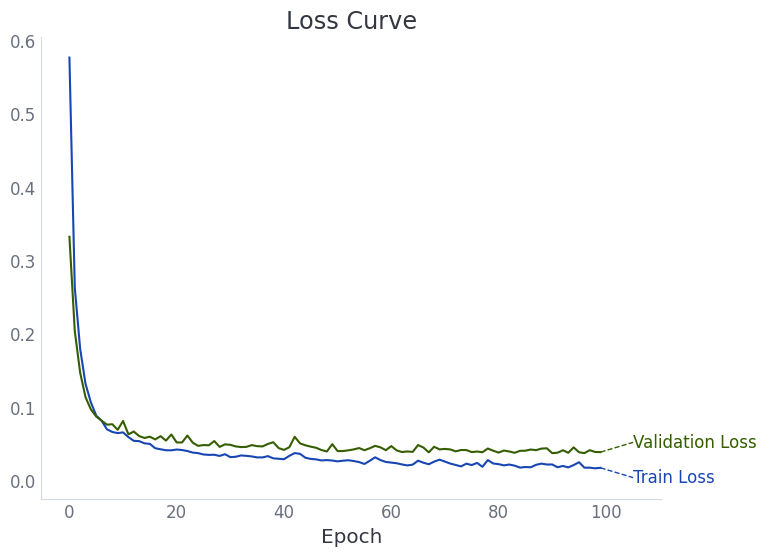

In [26]:
hist.set_index('Epoch').plot()
rp.line_labels()
plt.title('Loss Curve');

Text(0, 0.5, 'True')

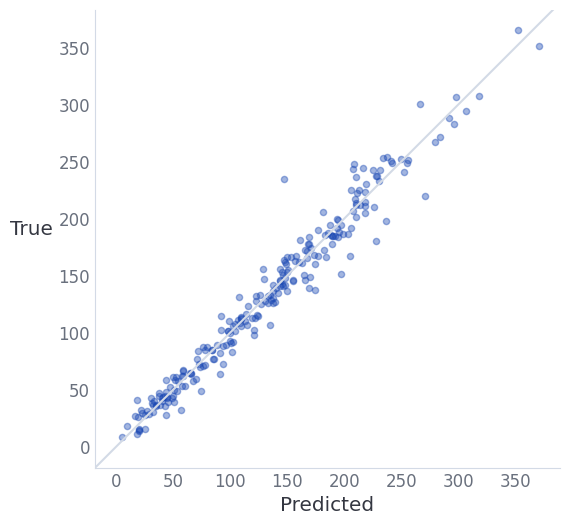

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(val_preds, val_true, alpha=0.4, s=20)
ax.set_aspect('equal')
ax.axline((0, 0), slope=1, color=plt.rcParams['axes.edgecolor'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True', rotation='horizontal', ha='right')

The [Matminer example](https://nbviewer.org/github/hackingmaterials/matminer_examples/blob/main/matminer_examples/machine_learning-nb/bulk_modulus.ipynb)
I took this dataset from got significantly worse results with a random forest: R2 of 0.924, RMSE of
19.277. Go deep learning!